# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Wed May 22 05:13:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [4]:
batch_size = 32
img_size = 224

data_dir = '/kaggle/input/skin-disease-train/binary'

In [5]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

무증상 189376
유증상 186746


In [6]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomHorizontalFlip,
    RandomVerticalFlip
)

transforms = Compose(
        [
            ToTensor(),
            RandomHorizontalFlip(),
            RandomVerticalFlip()
        ]
    )

In [7]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [8]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [9]:
train_size = int(len(dataset)*0.6)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_size = int(len(valid_dataset)*0.8)
valid_size = len(valid_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(valid_dataset, [train_size, valid_size])

In [10]:
print(len(train_dataset), len(valid_dataset))

120359 30090


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [12]:
def imshow(img):

    img = img.numpy().transpose((1, 2, 0))

    # mean = feature_extractor.image_mean
    # std = feature_extractor.image_std
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.show()

tensor(0)


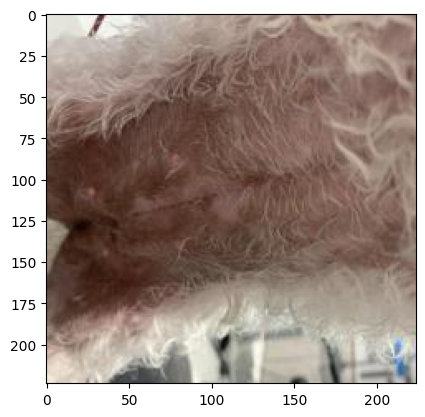

In [13]:
for data in train_loader:
    print(data[1][0])
    imshow(data[0][0])
    break

# Model Training

In [12]:
# inception_v4 resnet50 resnetv2_50 efficientnet_b0
# vit_base_resnet50_224_in21k vit_base_patch16_224 vit_base_patch8_224

In [21]:
model_name = 'resnet50'
pretrained = False
model = timm.create_model(model_name, pretrained=pretrained, num_classes=2048).to(device)

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [33]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [34]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [16]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [17]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [23]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=len(dataset.classes)): 
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(2048, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return self.sigmoid(x)

In [24]:
classifier = Classifier(model, num_classes=2)

In [20]:
for i, (name, param) in enumerate(classifier.named_parameters()):
    if param.requires_grad:
      print(i, name)

0 model.conv1.weight
1 model.bn1.weight
2 model.bn1.bias
3 model.layer1.0.conv1.weight
4 model.layer1.0.bn1.weight
5 model.layer1.0.bn1.bias
6 model.layer1.0.conv2.weight
7 model.layer1.0.bn2.weight
8 model.layer1.0.bn2.bias
9 model.layer1.0.conv3.weight
10 model.layer1.0.bn3.weight
11 model.layer1.0.bn3.bias
12 model.layer1.0.downsample.0.weight
13 model.layer1.0.downsample.1.weight
14 model.layer1.0.downsample.1.bias
15 model.layer1.1.conv1.weight
16 model.layer1.1.bn1.weight
17 model.layer1.1.bn1.bias
18 model.layer1.1.conv2.weight
19 model.layer1.1.bn2.weight
20 model.layer1.1.bn2.bias
21 model.layer1.1.conv3.weight
22 model.layer1.1.bn3.weight
23 model.layer1.1.bn3.bias
24 model.layer1.2.conv1.weight
25 model.layer1.2.bn1.weight
26 model.layer1.2.bn1.bias
27 model.layer1.2.conv2.weight
28 model.layer1.2.bn2.weight
29 model.layer1.2.bn2.bias
30 model.layer1.2.conv3.weight
31 model.layer1.2.bn3.weight
32 model.layer1.2.bn3.bias
33 model.layer2.0.conv1.weight
34 model.layer2.0.bn1.we

In [25]:
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5 , momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.05, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [26]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, 
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):
    
    model_dict = OrderedDict([(k, v) for k, v in model.state_dict().items()])
    state = {
        'epoch': epoch,
        'state_dict': model_dict,
        'optimizer': optimizer.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [27]:
model_path = '/kaggle/working/binary'
os.makedirs(model_path, exist_ok=True)

In [28]:
def load_dict(model, optimizer, dict_file):
    
    pretrained = torch.load(dict_file)
    
    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    labels = pretrained['label']
    
    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)
    
    optimizer.load_state_dict(opt_dict)
    
    return epoch, labels, model, optimizer

In [29]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [30]:
file_path = '/kaggle/input/skin-dog'

pretrained = False

In [31]:
num_epochs = 30

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}.pt')
    pkl_file = os.path.join(file_path, f'v{model_name}.pickle')
    
    epoch_start, labels, model, optimizer = load_dict(model, optimizer, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']

In [32]:
labels = dataset.classes
labels

['무증상', '유증상']

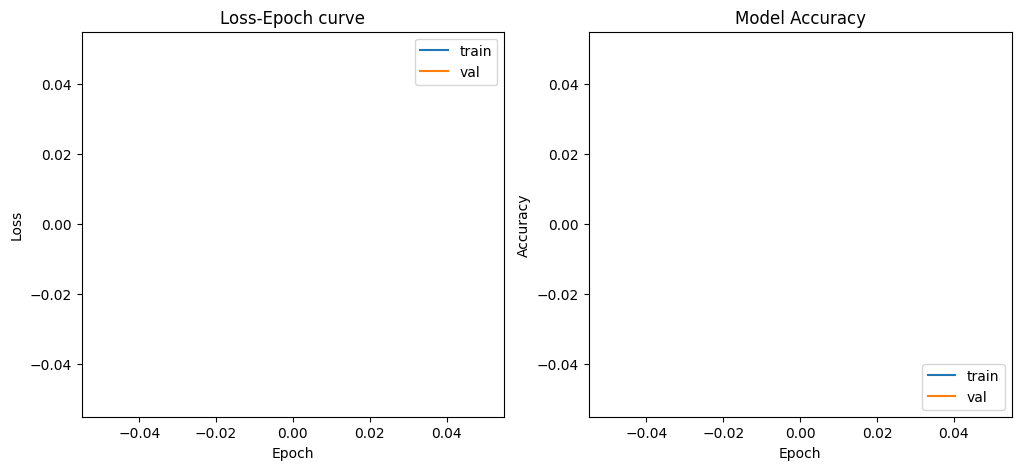

In [33]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

epoch 4 train acc 0.6197323327257538 validation acc 0.6200850159404888


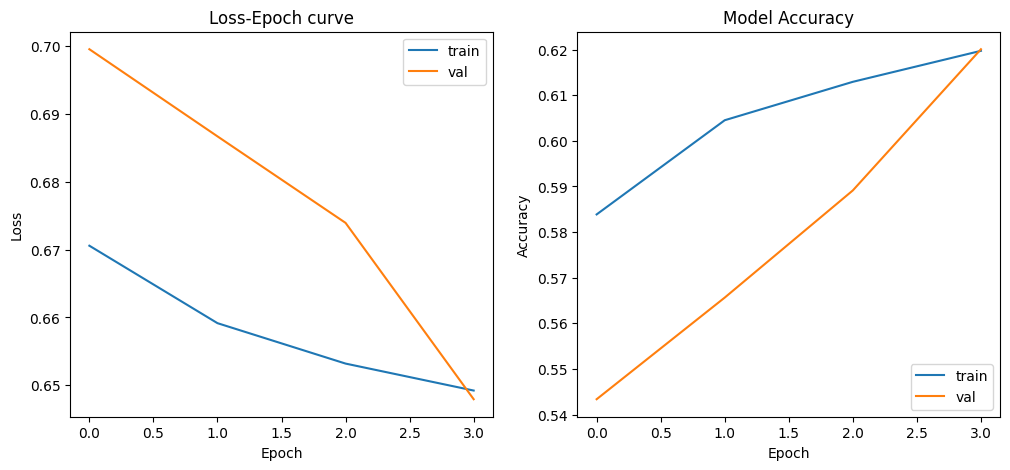

  0%|          | 0/3762 [00:00<?, ?it/s]

In [ ]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    classifier.eval()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1)

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
        
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, 
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, model_name)

In [ ]:
# Resnet50 binary

# Inference

In [ ]:
def inference(img_path):
    
    img = Image.open('/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg')
    encoding = feature_extractor(images=img, return_tensors='pt')
    
    outputs = classifier(encoding['pixel_values'])
    result = outputs.logits.softmax(1)
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[id2label[str(i)]] = value
        
    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)
    
    return result

In [ ]:
file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
result = inference(file_path)
print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')

In [ ]:
img = Image.open('/kaggle/input/skin-cat/test_cat_resized/A2_비듬_각질_상피성잔고리/IMG_C_A2_201688.jpg')
encoding = feature_extractor(images=img, return_tensors='pt')

In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime
import time

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: encoding['pixel_values'].numpy()}

s = time.time()
ort_outs = ort_session.run(None, ort_inputs)
e = time.time()

print(f'inference takes {e-s} sec')

In [ ]:
from scipy.special import softmax

In [ ]:
softmax(ort_outs)

In [ ]:
encoding['pixel_values'].size()

In [ ]:
ort_inputs

In [ ]:
dataset.class_to_idx

In [ ]:
import pickle

with open('/kaggle/working/classes.pkl', 'wb') as f:
    pickle.dump(id2label, f)

In [ ]:
with open('/kaggle/working/classes.pkl', 'rb') as f:
    classes = pickle.load(f)
classes

In [ ]:
result = softmax(ort_outs)
result

In [ ]:
result[0][0]

In [ ]:
result = softmax(ort_outs)
result_dict = {}

for i, value in enumerate(result[0][0].tolist()):
    result_dict[classes[str(i)]] = value
        
    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)
    
result

In [ ]:
result[:3]

In [ ]:
for i, (k, v) in enumerate(result[:3]):
    print(f"{k}일 확률 {int(v*100)}%")